# Comparison of some situations
For the tumour type and the euclidean distance for pruning, we test some situations :
1. When the mutational signatures are normalized and when there are not normalized, and when we do not include mutational signatures.
2. When the pre-graph is fully connected and when it's built with tumour type split.
3. When we include only the mutational signatures, and when we include mutational signatures with the other biomarkers, and when we do not include mutational signatures. For this case, we print the weights associated to each mutational signatures, to see which mutational signatures are really important.

# Table of contents

0. [Reading dataset](#0-reading-dataset)
1. [Compare normalized sigmut and non normalized sigmut](#1-compare-normalized-nonnormalized)
    1. [No sigmut](#1-no-sigmut)
    2. [Sigmut not normalized](#2-sigmut-not-normalized)
    3. [Sigmut normalized](#3-sigmut-not-normalized)
    4. [Compare](#4-compare)
2. [Compare fully connected graph and expert knowledge built graph](#2-compare-fc-expert)
    1. [Fully connected](#1-fully-connected)
    2. [Tumour type](#2-tumour-type)
3. [Compare only sigmut and sigmut+other biomarkers](#3-compare-sigmut+others)
    1. [Only sigmut](#1-only-sigmut)
    2. [Without sigmut](#2-without-sigmut)
    3. [Sigmut + others](#3-sigmut+others)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.BinaryClassifierTrainTestManager import BinaryClassifierTrainTestManager
from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

from models.BinaryClassifier import BinaryClassifier
from models.GCNClassifier import GCNClassifier

from utils.preProcessing import preProcessing

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, manhattan_distances
from sklearn.preprocessing import StandardScaler

## 0. Reading dataset

In [11]:
## No mutational signatures
df_no_sigmut = pd.read_excel('data/Supplemental-table1.xlsx')
df_no_sigmut = df_no_sigmut.loc[df_no_sigmut["Cohort"] == "Naive"]
df_no_sigmut = preProcessing.delete_nan_values(df_no_sigmut)


## Mutational signatures
df_sigmut = pd.read_excel('data/table-s1-sigmut-indel.xlsx')
df_sigmut = df_sigmut.loc[df_sigmut["Cohort"] == "Naive"]
df_sigmut = preProcessing.delete_nan_values(df_sigmut)

## 1. Compare normalized / non normalized mutational signatures
We can see in the table that the mutational signatures contains a lot of 0 values. So, the mean is around 0 and the standard deviation is low. So the normalized data may be high, and maybe can cause problem on predictions. So we test the case where we normalize these mutational signatures, and the case where we do not normalized them.

### A. No sigmut

##### Select features and normalize

In [12]:
# Select and normalize features
features_name_no_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]
X_no_sigmut = df_no_sigmut.loc[:,features_name_no_sigmut].to_numpy()

# Normalize data
X_no_sigmut = preProcessing.normalize_data(X_no_sigmut)

# Numerize label
label_name = "Clinical benefit"
y_no_sigmut = np.where(df_no_sigmut[label_name]=="DCB",1,0)

##### Instanciate classifier

In [13]:
# Instanciate GCN classifier
gcn_clf_no_sigmut = GCNClassifier(len(features_name_no_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_no_sigmut = GCNClassifierTrainTestManager(gcn_clf_no_sigmut)

##### Train model

In [14]:
n_epochs = 15

In [15]:
# Group labels for connecting patients (pre-graph)
group_no_sigmut = df_no_sigmut["Tumour type"].to_numpy()

## Leave one out CV
test_scores_gcn_no_sigmut, test_classes_gcn_no_sigmut, train_losses, val_losses, std_train, std_val, params_conv_no_sigmut, params_linear_no_sigmut = gcn_manager_no_sigmut.leave_one_out_cross_validation(X_no_sigmut, y_no_sigmut, group_no_sigmut, n_epochs, "euclidean", 3)

#### Plot loss

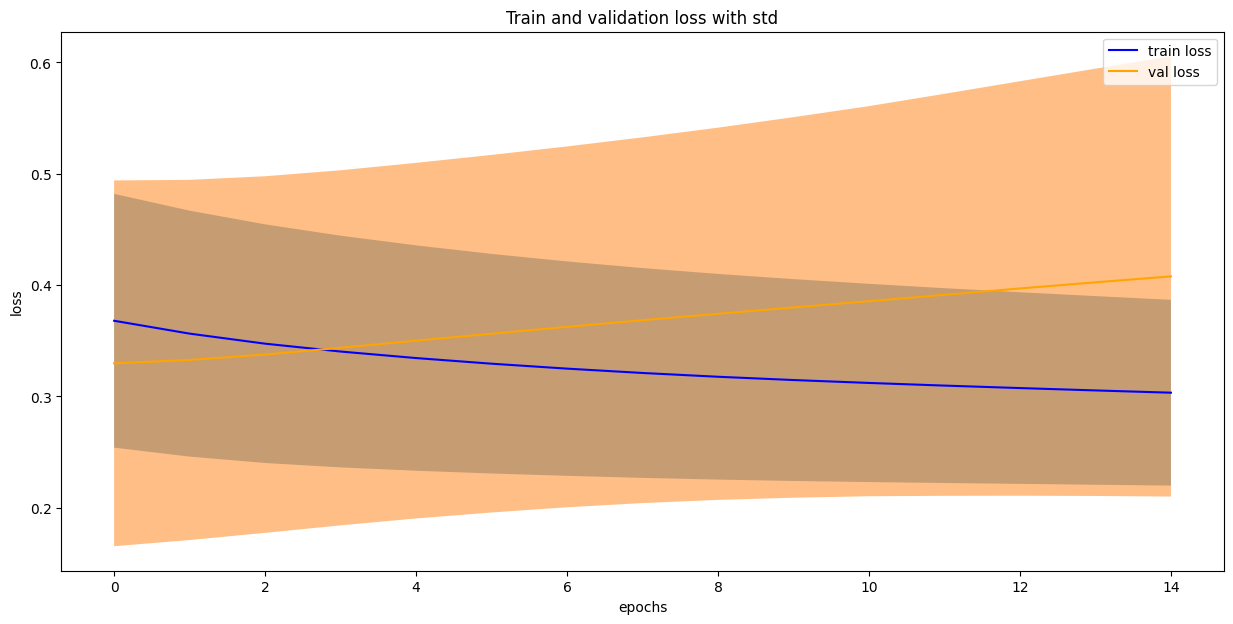

In [16]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(epochs, train_losses, color='blue',label='train loss')
ax.fill_between(epochs, train_losses-std_train, train_losses+std_train, alpha=0.5)
ax.plot(epochs, val_losses, color='orange',label='val loss')
ax.fill_between(epochs, val_losses-std_val, val_losses+std_val,alpha=0.5)
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Train and validation loss with std')
plt.legend()

#### Plot weights per features

In [6]:
# Take the absolute value
weights_conv_no_sigmut = np.absolute(np.mean(params_conv_no_sigmut[0].detach().numpy(),axis=1))
weights_linear_no_sigmut = np.absolute(params_linear_no_sigmut[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - no sigmut')

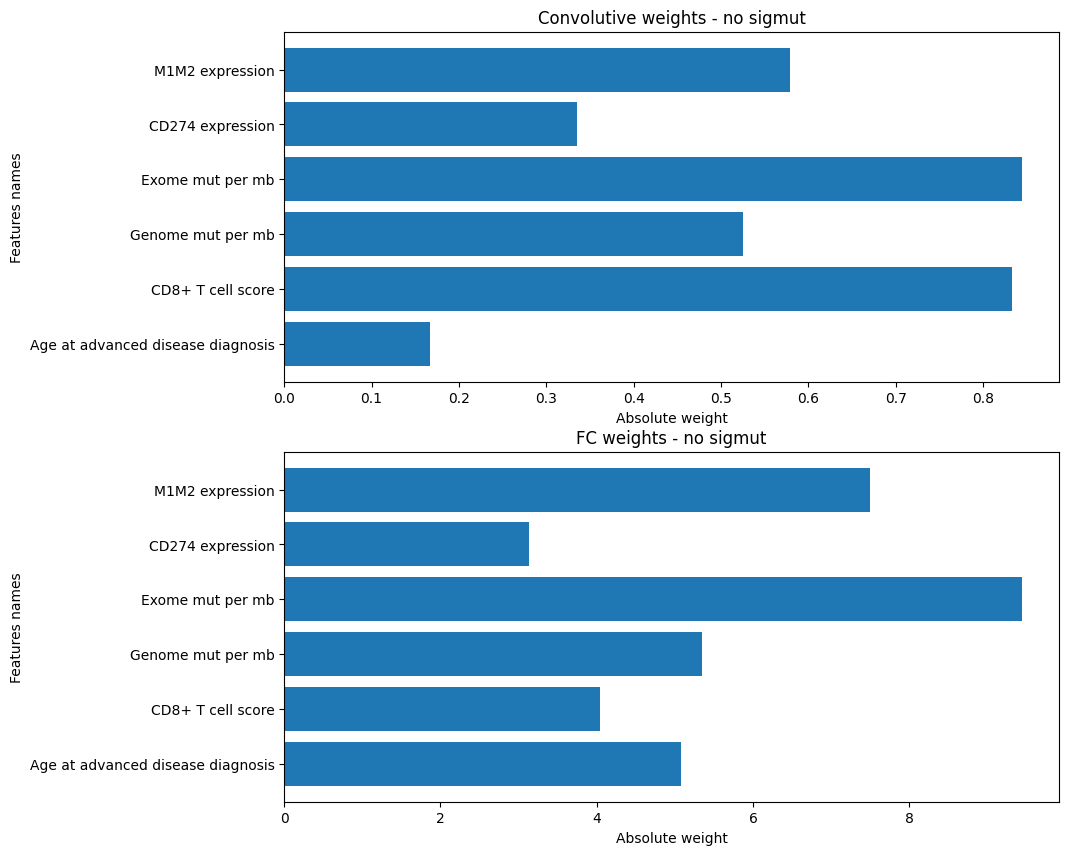

In [7]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].barh(features_name_no_sigmut,weights_conv_no_sigmut)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Convolutive weights - no sigmut")

ax[1].barh(features_name_no_sigmut,weights_linear_no_sigmut)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("FC weights - no sigmut")

### B. Not normalized mutational signatures

##### Select features

In [8]:
# Select features
features_name_sigmut = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df_sigmut.loc[:,features_to_normalize] = StandardScaler().fit_transform(df_sigmut.loc[:,features_to_normalize].to_numpy())

# Extract features
X_sigmut_non_normalized = df_sigmut.loc[:,features_name_sigmut].to_numpy()

# Numerize label
y_sigmut = np.where(df_sigmut[label_name]=="DCB",1,0)

##### Instanciate classifier

In [9]:
# Instanciate GCN classifier
gcn_clf_sigmut_non_normalized = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_sigmut_non_normalized = GCNClassifierTrainTestManager(gcn_clf_sigmut_non_normalized)

##### Train classifier

In [10]:
## Group (tumour type) to build pre-graph
group_sigmut = df_sigmut["Tumour type"].to_numpy()

## Leave one out CV
test_scores_gcn_sigmut_non_normalized, test_classes_gcn_sigmut_non_normalized,params_conv_sigmut_non_normalized,params_linear_sigmut_non_normalized = gcn_manager_sigmut_non_normalized.leave_one_out_cross_validation(X_sigmut_non_normalized, y_sigmut, group_sigmut, 50, "euclidean", 3)

In [11]:
# Take the absolute value
weights_conv_sigmut_non_normalized = np.absolute(np.mean(params_conv_sigmut_non_normalized[0].detach().numpy(),axis=1))
weights_linear_sigmut_non_normalized = np.absolute(params_linear_sigmut_non_normalized[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - sigmut not normalized')

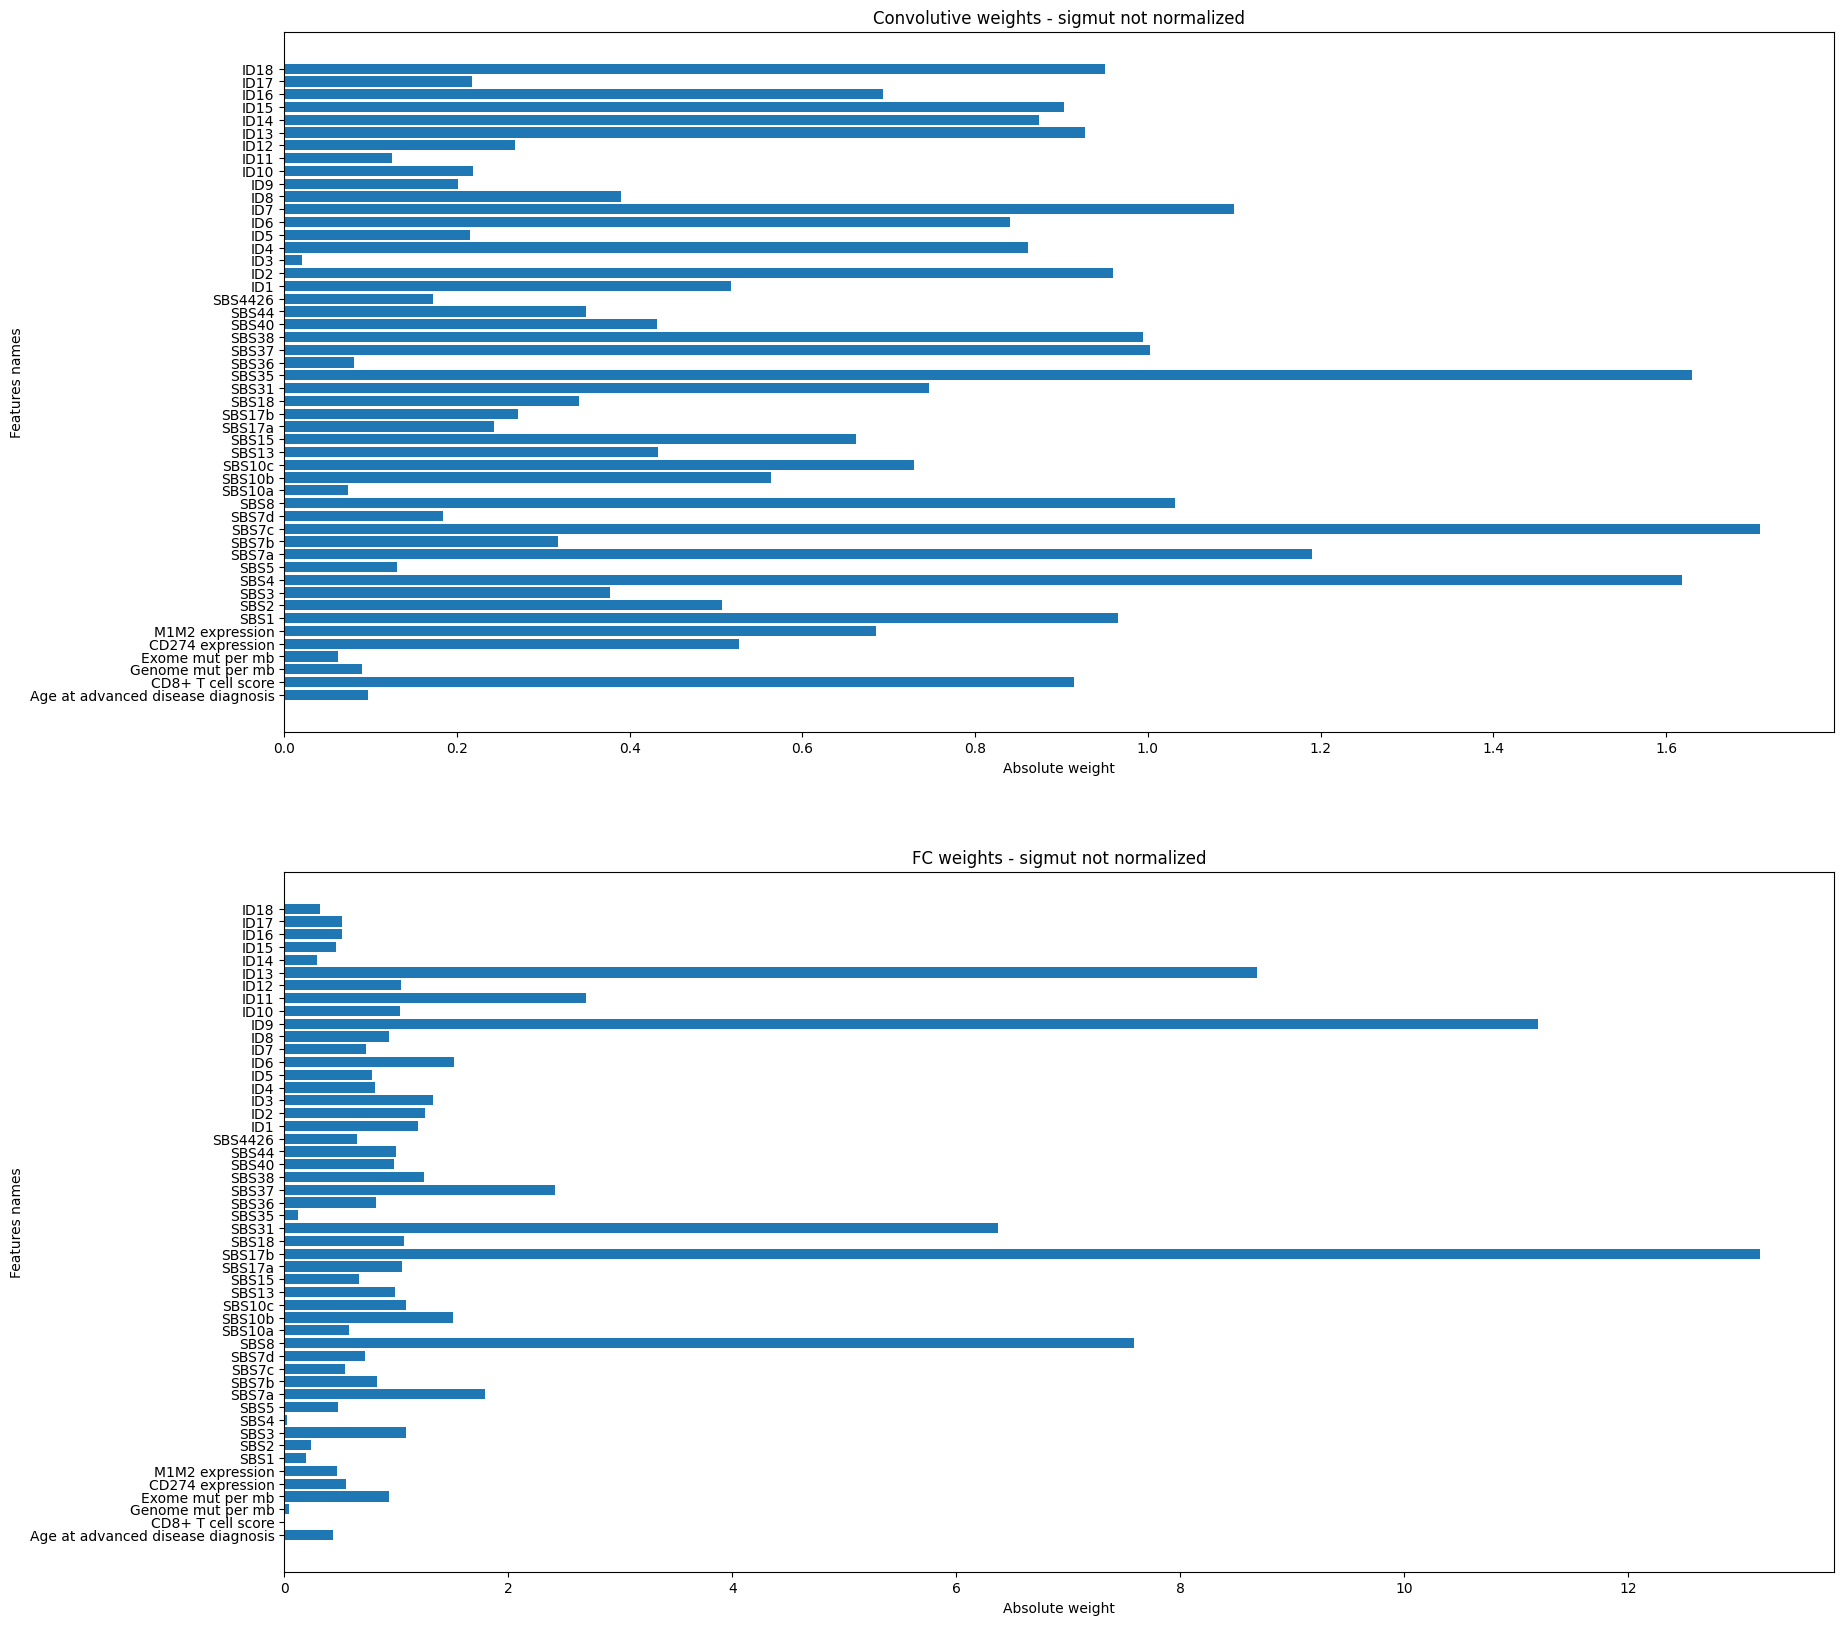

In [12]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

ax[0].barh(features_name_sigmut,weights_conv_sigmut_non_normalized)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Convolutive weights - sigmut not normalized")

ax[1].barh(features_name_sigmut,weights_linear_sigmut_non_normalized)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("FC weights - sigmut not normalized")

### C. Normalized

In [13]:
# Normalize features except mutational signatures
df_sigmut.loc[:,features_name_sigmut] = StandardScaler().fit_transform(df_sigmut.loc[:,features_name_sigmut].to_numpy())

# Extract features
X_sigmut_normalized = df_sigmut.loc[:,features_name_sigmut].to_numpy()

In [14]:
# Instanciate GCN classifier
gcn_clf_sigmut_normalized = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_sigmut_normalized = GCNClassifierTrainTestManager(gcn_clf_sigmut_normalized)

In [15]:
## Leave one out CV
test_scores_gcn_sigmut_normalized, test_classes_gcn_sigmut_normalized,params_conv_sigmut_normalized,params_linear_sigmut_normalized = gcn_manager_sigmut_normalized.leave_one_out_cross_validation(X_sigmut_normalized, y_sigmut, group_sigmut, 50, "euclidean", 3)

In [16]:
# Take the absolute value
weights_conv_sigmut_normalized = np.absolute(np.mean(params_conv_sigmut_normalized[0].detach().numpy(),axis=1))
weights_linear_sigmut_normalized = np.absolute(params_linear_sigmut_normalized[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - sigmut normalized')

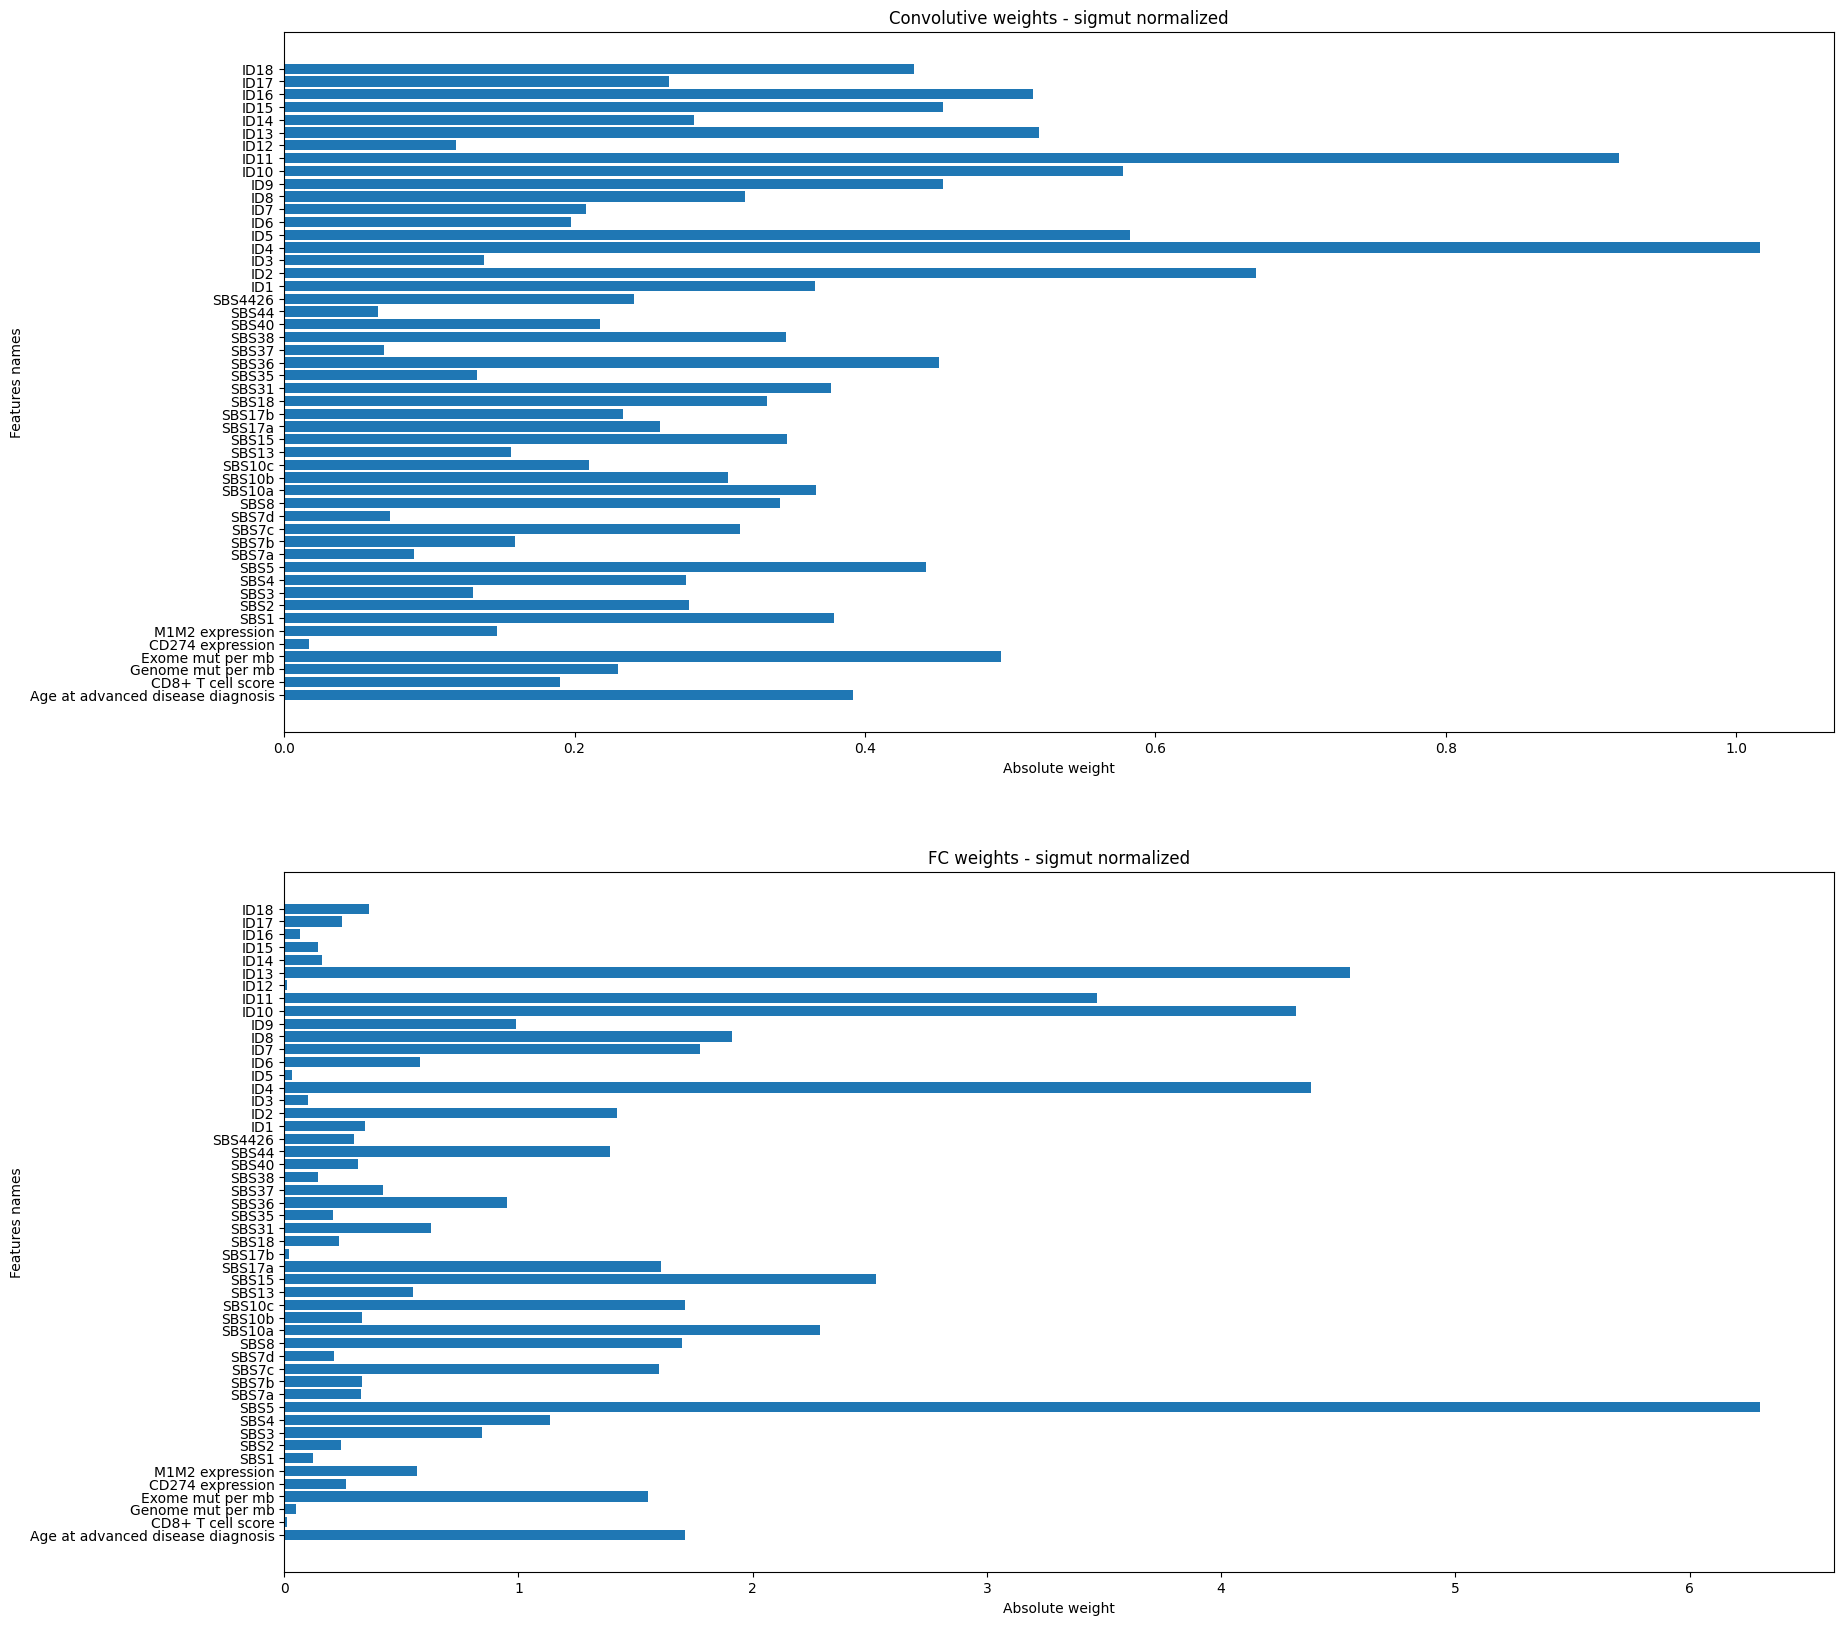

In [17]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

ax[0].barh(features_name_sigmut,weights_conv_sigmut_normalized)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Convolutive weights - sigmut normalized")

ax[1].barh(features_name_sigmut,weights_linear_sigmut_normalized)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("FC weights - sigmut normalized")

#### D. Compare performances

In [18]:
## No sigmut
pre_gcn_no_sigmut, rec_gcn_no_sigmut, f1_gcn_no_sigmut = ClassificationMetrics.eval_metrics_from_conf_matrix(y_no_sigmut, test_classes_gcn_no_sigmut)
fpr_gcn_no_sigmut, tpr_gcn_no_sigmut, thresholds_gcn_no_sigmut = ClassificationMetrics.compute_roc_curve(y_no_sigmut, test_scores_gcn_no_sigmut)
auc_gcn_no_sigmut = ClassificationMetrics.compute_auc(y_no_sigmut, test_scores_gcn_no_sigmut)

## Sigmut non normalized
pre_gcn_sigmut_non_normalized, rec_gcn_sigmut_non_normalized, f1_gcn_sigmut_non_normalized = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_non_normalized)
fpr_gcn_sigmut_non_normalized, tpr_gcn_sigmut_non_normalized, thresholds_gcn_sigmut_non_normalized = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_non_normalized)
auc_gcn_sigmut_non_normalized = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_non_normalized)

## Sigmut normalized
pre_gcn_sigmut_normalized, rec_gcn_sigmut_normalized, f1_gcn_sigmut_normalized = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_sigmut_normalized)
fpr_gcn_sigmut_normalized, tpr_gcn_sigmut_normalized, thresholds_gcn_sigmut_normalized = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_sigmut_normalized)
auc_gcn_sigmut_normalized = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_sigmut_normalized)

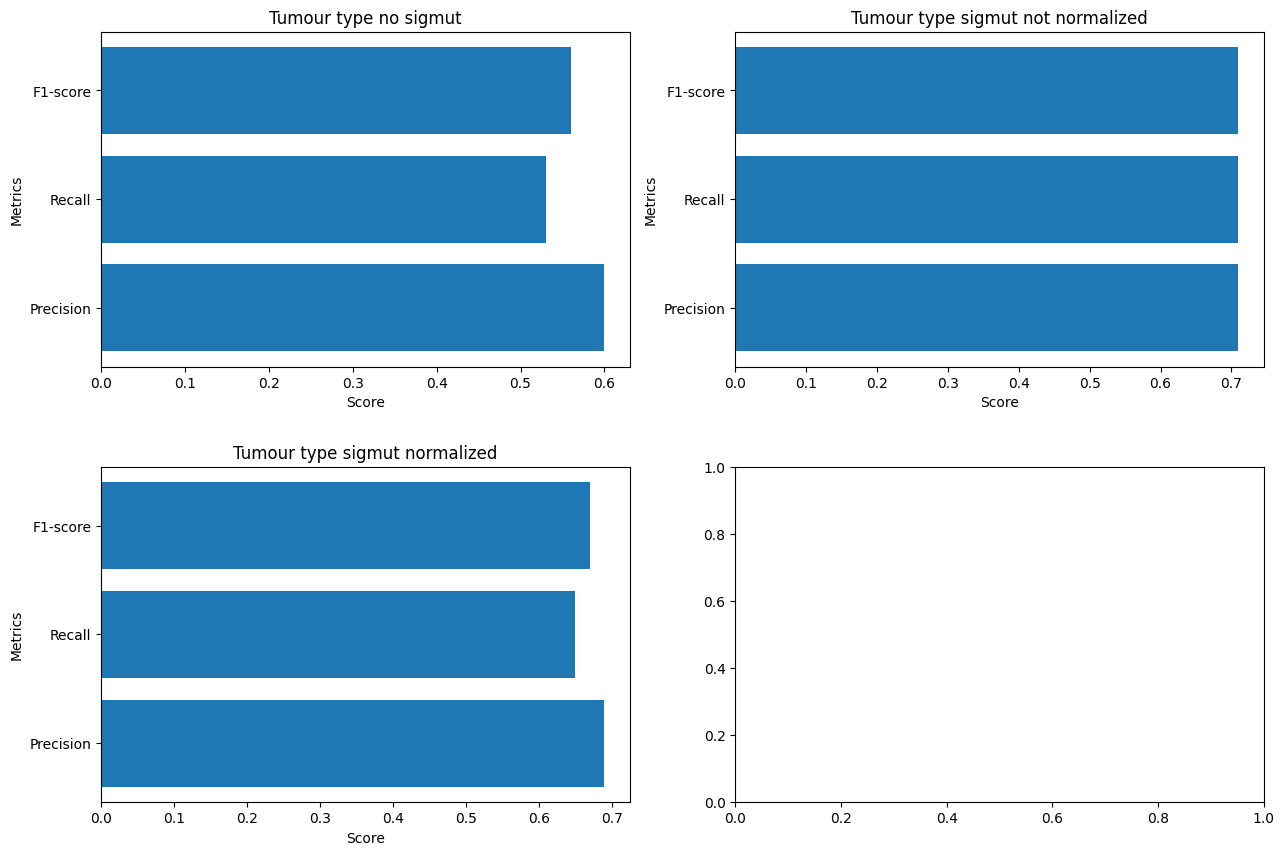

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].barh(["Precision","Recall","F1-score"],[pre_gcn_no_sigmut, rec_gcn_no_sigmut, f1_gcn_no_sigmut])
ax[0,0].set_xlabel("Score")
ax[0,0].set_ylabel("Metrics")
ax[0,0].set_title("Tumour type no sigmut")

ax[0,1].barh(["Precision","Recall","F1-score"],[pre_gcn_sigmut_non_normalized, rec_gcn_sigmut_non_normalized, f1_gcn_sigmut_non_normalized])
ax[0,1].set_xlabel("Score")
ax[0,1].set_ylabel("Metrics")
ax[0,1].set_title("Tumour type sigmut not normalized")

ax[1,0].barh(["Precision","Recall","F1-score"],[pre_gcn_sigmut_normalized, rec_gcn_sigmut_normalized, f1_gcn_sigmut_normalized])
ax[1,0].set_xlabel("Score")
ax[1,0].set_ylabel("Metrics")
ax[1,0].set_title("Tumour type sigmut normalized")

plt.subplots_adjust(hspace=0.3)

Text(0, 0.6, 'AUC sigmut normalized : 0.92')

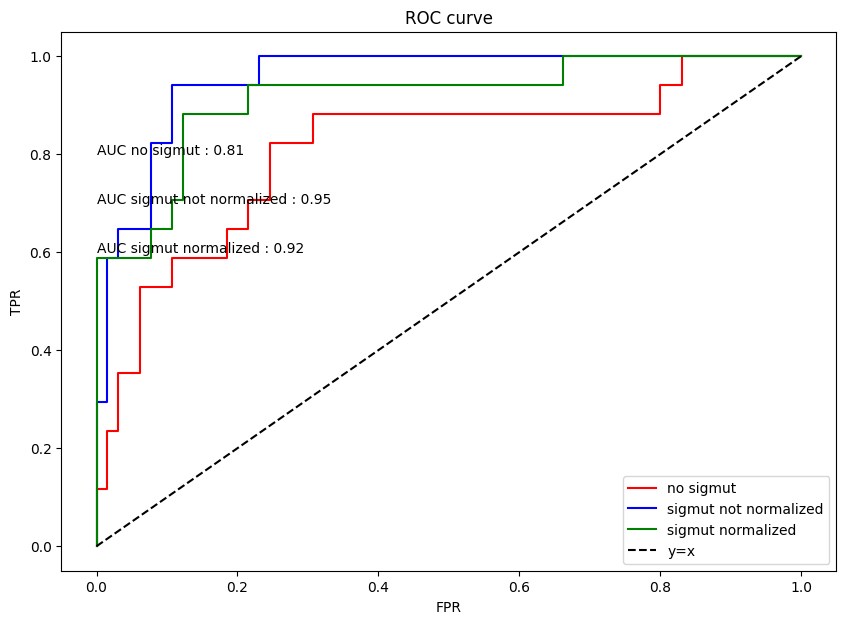

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)

# No sigmut :
ax.plot(fpr_gcn_no_sigmut, tpr_gcn_no_sigmut, color='red',label='no sigmut')
ax.plot(fpr_gcn_sigmut_non_normalized, tpr_gcn_sigmut_non_normalized, color='blue',label='sigmut not normalized')
ax.plot(fpr_gcn_sigmut_normalized, tpr_gcn_sigmut_normalized, color='green',label='sigmut normalized')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve')
ax.legend()
ax.text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut}")
ax.text(0,0.7,f"AUC sigmut not normalized : {auc_gcn_sigmut_non_normalized}")
ax.text(0,0.6,f"AUC sigmut normalized : {auc_gcn_sigmut_normalized}")

## 2. Compare fully connected graph and expert knowledge graph
Before pruning the graph, we build a pre-graph. Here, we want to test a fully-connected pre-graph, and a pre-graph built with expert knowledge (per tumour type)

We'll test with sigmut non normalized, because we can see above we have better performances.

### A. Fully connected

In [21]:
# All patients in the same group
group_fully_connected = np.array([0 for k in range(df_sigmut.shape[0])])

In [22]:
# Instanciate GCN classifier
gcn_clf_fully_connected = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_fully_connected = GCNClassifierTrainTestManager(gcn_clf_fully_connected)

In [23]:
test_scores_gcn_fully_connected, test_classes_gcn_fully_connected, params_conv_fc, params_linear_fc = gcn_manager_fully_connected.leave_one_out_cross_validation(X_sigmut_non_normalized, y_sigmut, group_fully_connected, 50, "euclidean", 3)

### B. Per Tumour type
Already done in section 1 !

### C. Compare

In [24]:
## Fully connected
pre_gcn_fully_connected, rec_gcn_fully_connected, f1_gcn_fully_connected = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_fully_connected)
fpr_gcn_fully_connected, tpr_gcn_fully_connected, thresholds_gcn_fully_connected = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_fully_connected)
auc_gcn_fully_connected = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_fully_connected)

Text(0.5, 1.0, 'Tumour type')

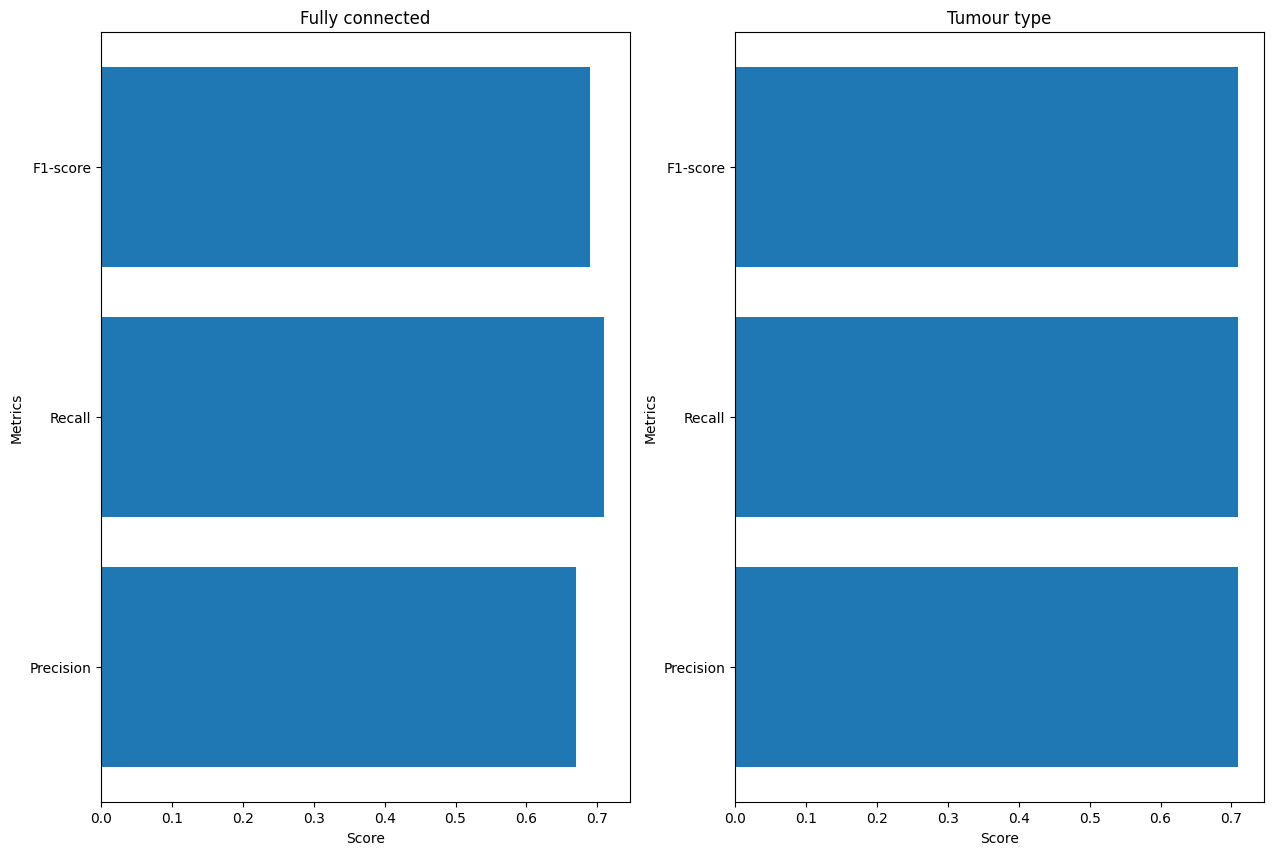

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,10))

ax[0].barh(["Precision","Recall","F1-score"],[pre_gcn_fully_connected, rec_gcn_fully_connected, f1_gcn_fully_connected])
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Metrics")
ax[0].set_title("Fully connected")

ax[1].barh(["Precision","Recall","F1-score"],[pre_gcn_sigmut_non_normalized, rec_gcn_sigmut_non_normalized, f1_gcn_sigmut_non_normalized])
ax[1].set_xlabel("Score")
ax[1].set_ylabel("Metrics")
ax[1].set_title("Tumour type")

Text(0, 0.7, 'AUC Tumour type : 0.95')

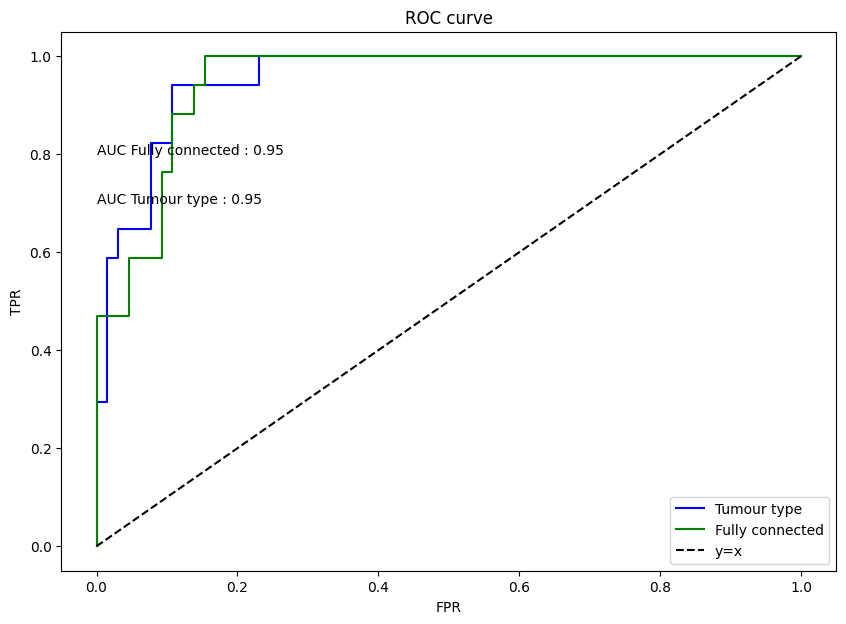

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)

# No sigmut :
ax.plot(fpr_gcn_sigmut_non_normalized, tpr_gcn_sigmut_non_normalized, color='blue',label='Tumour type')
ax.plot(fpr_gcn_fully_connected, tpr_gcn_fully_connected, color='green',label='Fully connected')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve')
ax.legend()
ax.text(0,0.8,f"AUC Fully connected : {auc_gcn_fully_connected}")
ax.text(0,0.7,f"AUC Tumour type : {auc_gcn_sigmut_non_normalized}")

## 2. Compare with only mutational signatures, with only other biomarkers, and with the combination of both
The performances are better with not normalized mutational signatures, so we keep them.

### A. Only mutational signatures

##### Select features

In [27]:
# Select features
features_name_sigmut = ["SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]

# Reading dataset another time because previous has been modified
df_sigmut = pd.read_excel('data/table-s1-sigmut-indel.xlsx')
df_sigmut = df_sigmut.loc[df_sigmut["Cohort"] == "Naive"]
df_sigmut = preProcessing.delete_nan_values(df_sigmut)

# Extract features
X_only_sigmut = df_sigmut.loc[:,features_name_sigmut].to_numpy()

# Numerize label
y_sigmut = np.where(df_sigmut[label_name]=="DCB",1,0)

##### Instanciate classifier

In [28]:
# Instanciate GCN classifier
gcn_clf_only_sigmut = GCNClassifier(len(features_name_sigmut))

# Instanciate the GCN train-test manager
gcn_manager_only_sigmut = GCNClassifierTrainTestManager(gcn_clf_only_sigmut)

##### Train the classifier

In [29]:
## Group (tumour type) to build pre-graph
group_sigmut = df_sigmut["Tumour type"].to_numpy()

## Leave one out CV
test_scores_gcn_only_sigmut, test_classes_gcn_only_sigmut,params_conv_only_sigmut,params_linear_only_sigmut = gcn_manager_only_sigmut.leave_one_out_cross_validation(X_only_sigmut, y_sigmut, group_sigmut, 50, "euclidean", 3)

In [30]:
# Take the absolute value
weights_conv_only_sigmut = np.absolute(np.mean(params_conv_only_sigmut[0].detach().numpy(),axis=1))
weights_linear_only_sigmut = np.absolute(params_linear_only_sigmut[0].detach().numpy())[0]

Text(0.5, 1.0, 'FC weights - sigmut not normalized')

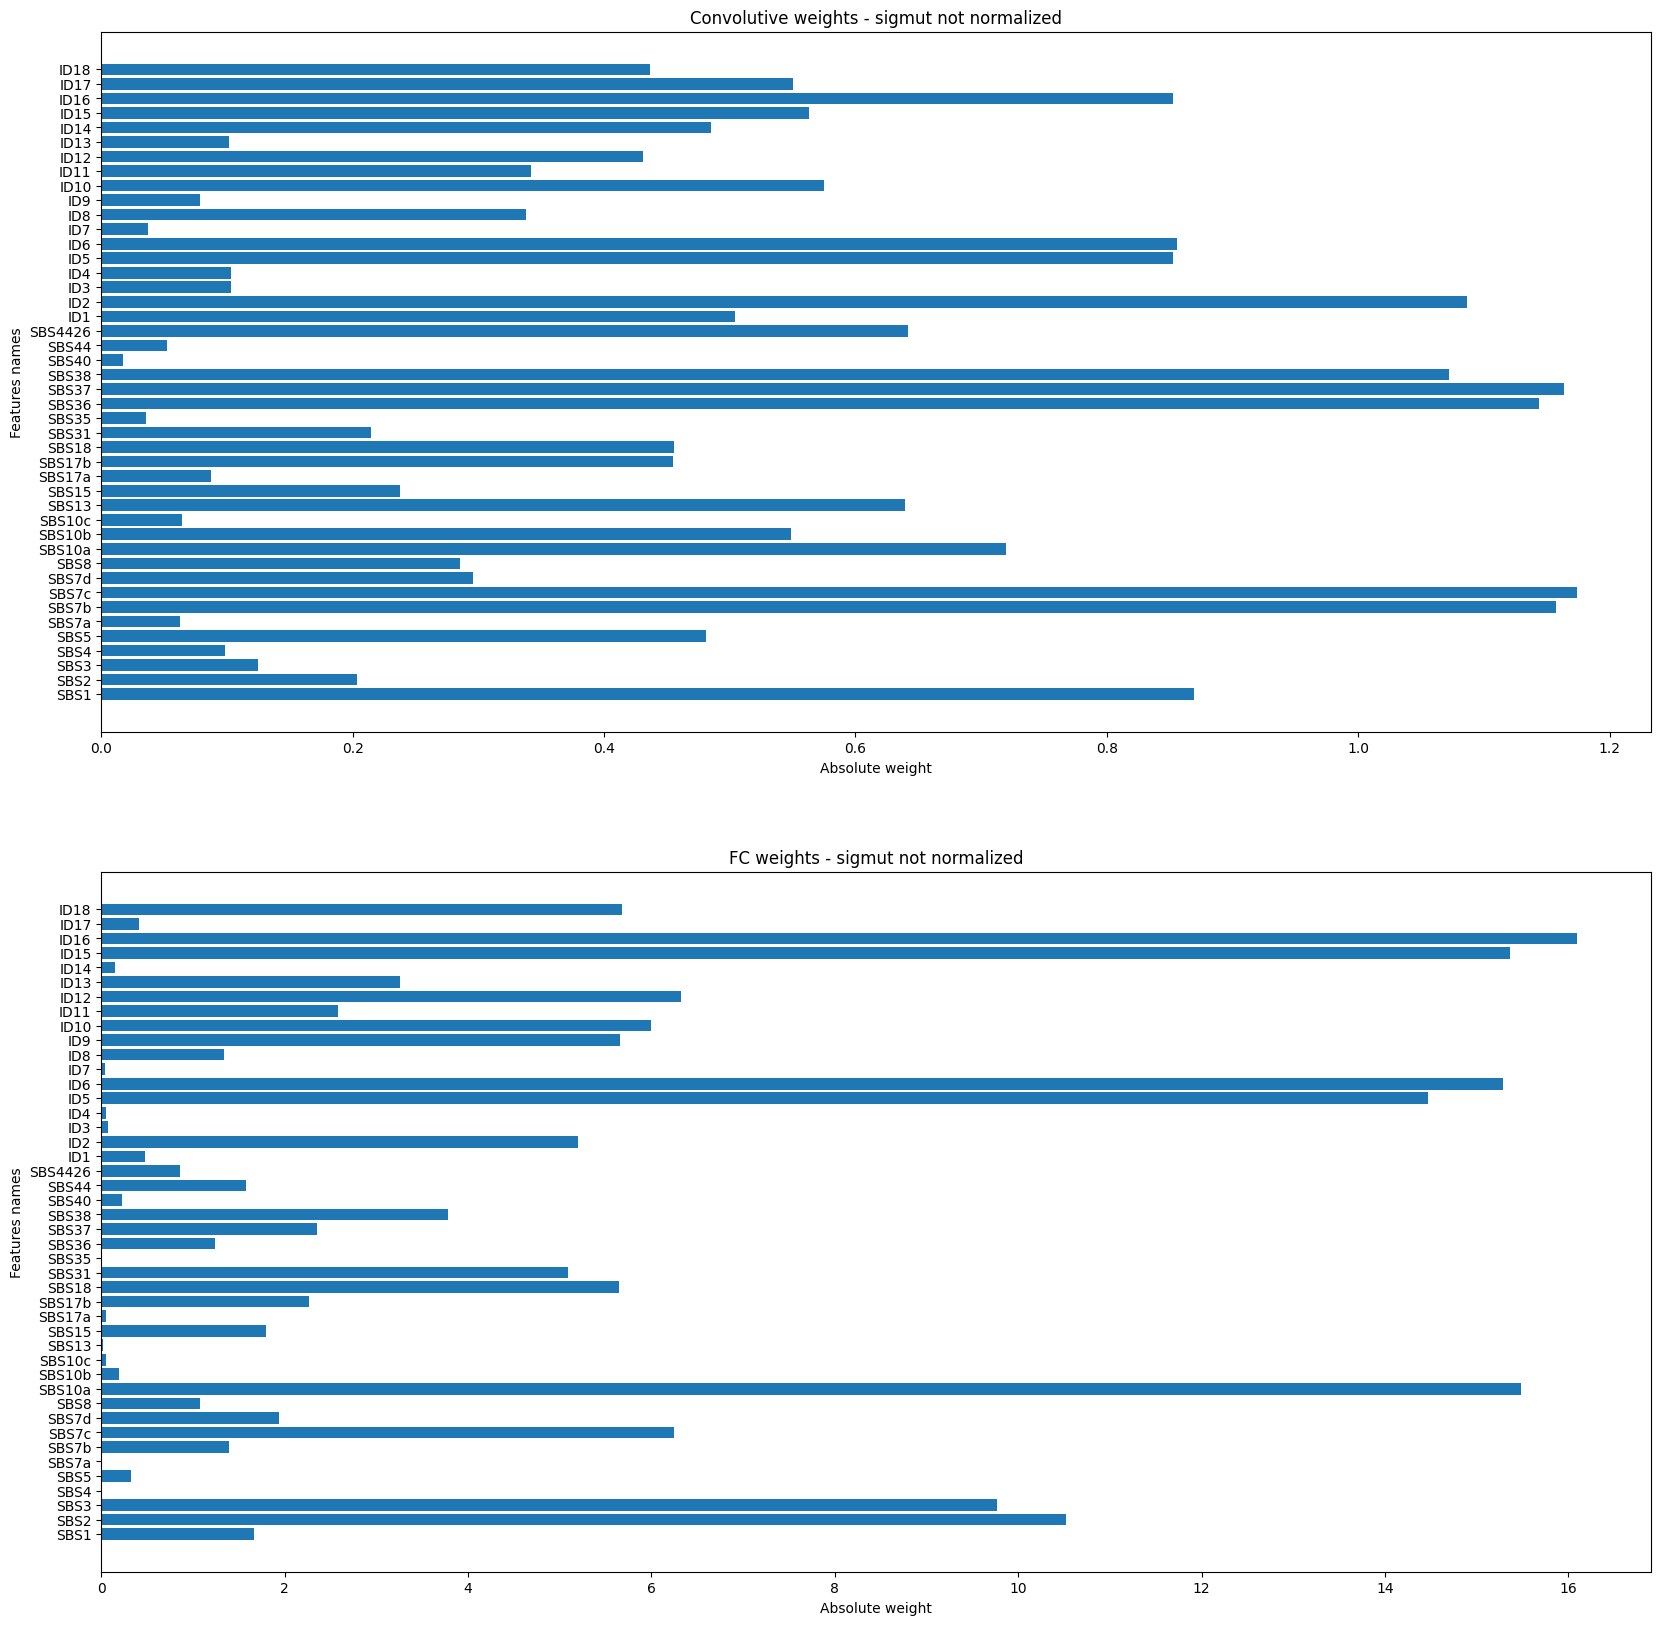

In [31]:
fig, ax = plt.subplots(2,1,figsize=(20,20))

ax[0].barh(features_name_sigmut,weights_conv_only_sigmut)
ax[0].set_ylabel("Features names")
ax[0].set_xlabel("Absolute weight")
ax[0].set_title("Convolutive weights - sigmut not normalized")

ax[1].barh(features_name_sigmut,weights_linear_only_sigmut)
ax[1].set_ylabel("Features names")
ax[1].set_xlabel("Absolute weight")
ax[1].set_title("FC weights - sigmut not normalized")

### B. Without mutational signatures
Already done in section 1 !

### C. Mutational signatures with other biomarkers
Already done in section 1 !

### D. Compare

In [32]:
## Only sigmut
pre_gcn_only_sigmut, rec_gcn_only_sigmut, f1_gcn_only_sigmut = ClassificationMetrics.eval_metrics_from_conf_matrix(y_sigmut, test_classes_gcn_only_sigmut)
fpr_gcn_only_sigmut, tpr_gcn_only_sigmut, thresholds_gcn_only_sigmut = ClassificationMetrics.compute_roc_curve(y_sigmut, test_scores_gcn_only_sigmut)
auc_gcn_only_sigmut = ClassificationMetrics.compute_auc(y_sigmut, test_scores_gcn_only_sigmut)

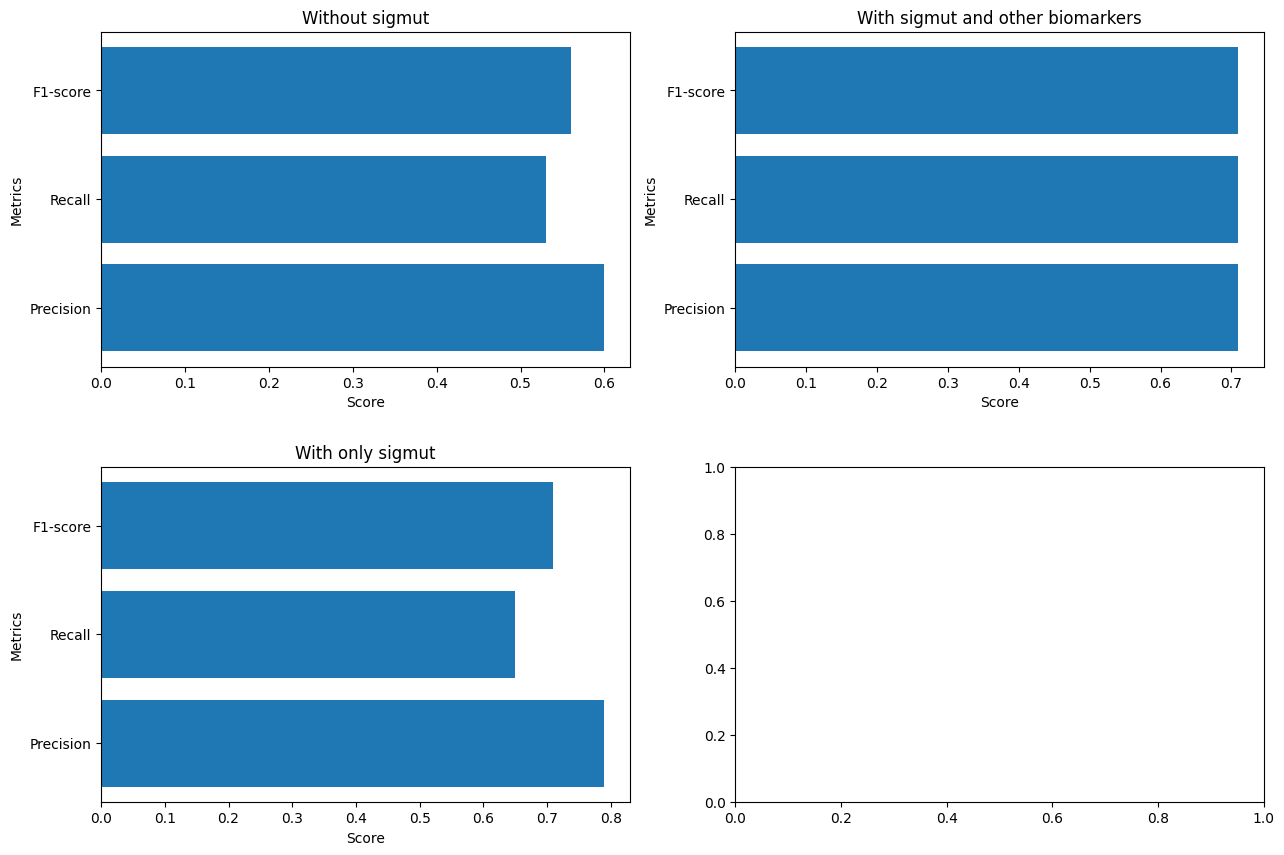

In [33]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].barh(["Precision","Recall","F1-score"],[pre_gcn_no_sigmut, rec_gcn_no_sigmut, f1_gcn_no_sigmut])
ax[0,0].set_xlabel("Score")
ax[0,0].set_ylabel("Metrics")
ax[0,0].set_title("Without sigmut")

ax[0,1].barh(["Precision","Recall","F1-score"],[pre_gcn_sigmut_non_normalized, rec_gcn_sigmut_non_normalized, f1_gcn_sigmut_non_normalized])
ax[0,1].set_xlabel("Score")
ax[0,1].set_ylabel("Metrics")
ax[0,1].set_title("With sigmut and other biomarkers")

ax[1,0].barh(["Precision","Recall","F1-score"],[pre_gcn_only_sigmut, rec_gcn_only_sigmut, f1_gcn_only_sigmut])
ax[1,0].set_xlabel("Score")
ax[1,0].set_ylabel("Metrics")
ax[1,0].set_title("With only sigmut")

plt.subplots_adjust(hspace=0.3)

Text(0, 0.6, 'AUC only sigmut : 0.93')

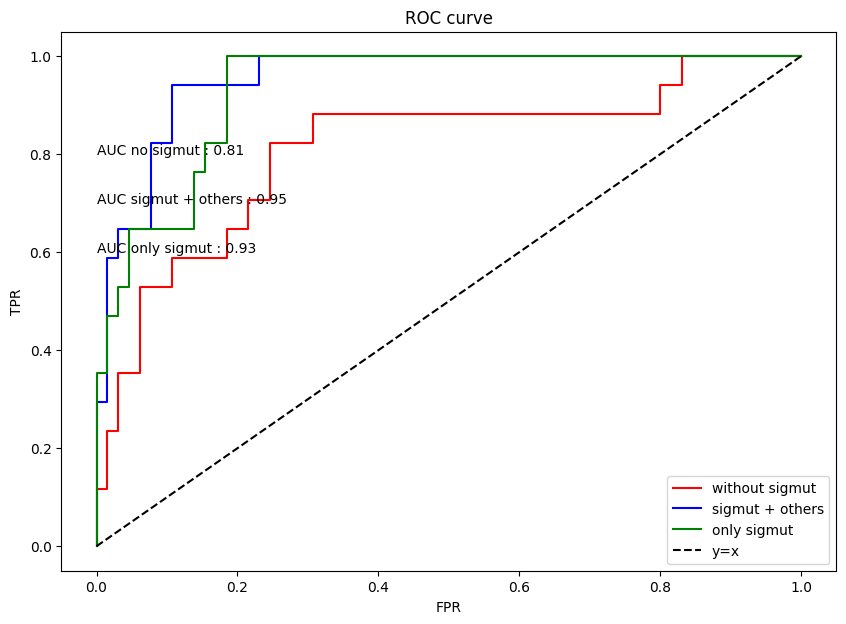

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
x = np.linspace(0,1,100)

# No sigmut :
ax.plot(fpr_gcn_no_sigmut, tpr_gcn_no_sigmut, color='red',label='without sigmut')
ax.plot(fpr_gcn_sigmut_non_normalized, tpr_gcn_sigmut_non_normalized, color='blue',label='sigmut + others')
ax.plot(fpr_gcn_only_sigmut, tpr_gcn_only_sigmut, color='green',label='only sigmut')
ax.plot(x,x,linestyle='--',color='black',label='y=x')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC curve')
ax.legend()
ax.text(0,0.8,f"AUC no sigmut : {auc_gcn_no_sigmut}")
ax.text(0,0.7,f"AUC sigmut + others : {auc_gcn_sigmut_non_normalized}")
ax.text(0,0.6,f"AUC only sigmut : {auc_gcn_only_sigmut}")